### Summary:
#### Goal: To build an algorithm to build the complexity of passages for grade 3-12 use
#### Data:
1. Train test: 
    * id - unique id/ primary key
    * url_legal:  URL source 
    * license: source material's license
    * exerpt: text to evaluate the readability level
    * target: the level of reability associated with that exerpt
    * standard error: measure the spread of scores among all raters for each exerpt
2. Test set:
    * id - unique id/ primary key
    * exerpt: text to evaluate the readability level
    
#### Evaluation metric: RMSE


In [1]:
#Import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns


In [2]:
#Read the dataset
train_dir ="../input/commonlitreadabilityprize/train.csv"
test_dir = "../input/commonlitreadabilityprize/test.csv"
submission_dir = "../input/commonlitreadabilityprize/sample_submission.csv"

train = pd.read_csv(train_dir)
print(train.shape)
test = pd.read_csv(test_dir)
print(test.shape)
submission = pd.read_csv(submission_dir)
print(submission.shape)


(2834, 6)
(7, 4)
(7, 2)


In [3]:
train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [4]:
test.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


## Missing values

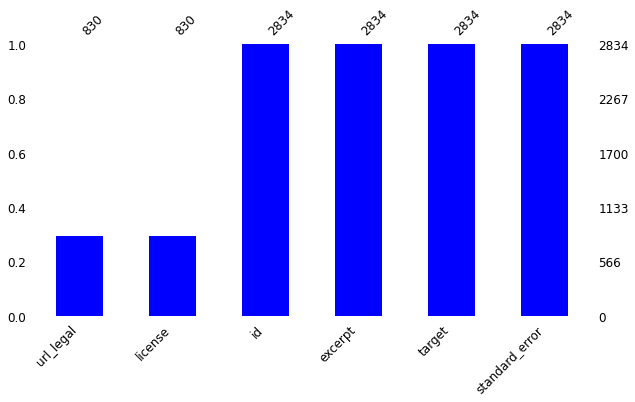

In [5]:
msno.bar(train, color = 'blue', sort = 'ascending',figsize = (10,5), fontsize = 12 )
plt.show()

# Preprocessed data

In [6]:
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize.treebank import TreebankWordDetokenizer, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import  unicodedata, re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

In [7]:
# build the preprocess
class TextPreprocess(object):   
    def __init__(self,
                do_remove_between_square_brackets = True,
                do_to_lower=True, 
                do_to_upper=False, 
                do_remove_number=False,
                do_remove_punctuation=True,
                do_split_on_white_space = True,
                do_remove_stopwords=True, 
                do_remove_short_tokens=False,
                do_remove_non_ascii_chars=False,
                do_stemming = True,
                do_tokenize=False):
        
        self.do_remove_between_square_brackets=do_remove_between_square_brackets
        self.do_to_lower=do_to_lower 
        self.do_to_upper=do_to_upper 
        self.do_remove_number=do_remove_number
        self.do_remove_punctuation=do_remove_punctuation 
        self.do_split_on_white_space=do_split_on_white_space 
        self.do_remove_stopwords=do_remove_stopwords 
        self.do_remove_short_tokens=do_remove_short_tokens
        self.do_remove_non_ascii_chars=do_remove_non_ascii_chars
        self.do_stemming = do_stemming
        self.do_tokenize=do_tokenize
                
        
    def remove_between_square_brackets(self, text):
        return re.sub('\[[^]]*\]', '', text)
    
    def to_lower(self, text):
        if type(text) is str:
            return text.lower()
    
    def to_upper(self, text):
        return text.upper()
    
    def remove_number(self, text):
        return re.sub(r'\d+', '', text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def split_on_white_space(self, text):
        if not text == None: 
            return text.split()
    
    def remove_stopwords(self, text):
        if not text == None:
            tokens = self.split_on_white_space(text)
            stop_words = set(stopwords.words('english'))
            tokens = [w for w in tokens if not w in stop_words]
            detokenizer = TreebankWordDetokenizer()
            text = detokenizer.detokenize(tokens)
            return text       
  

    def stem_sentence(self, text):
        porter=PorterStemmer()
        token_words=word_tokenize(text)
        token_words
        stem_sentence=[]
        for word in token_words:
            stem_sentence.append(porter.stem(word))
            stem_sentence.append(" ")
        return "".join(stem_sentence)
    
    def remove_short_tokens(self, text):
        tokens = self.split_on_white_space(text)
        if tokens:
            tokens = [token for token in tokens if len(token) > 1]
            detokenizer = TreebankWordDetokenizer()
            text = detokenizer.detokenize(tokens)
            return text

    def remove_non_ascii_chars(self, text):
        return unicodedata.normalize('NFKD', str(text)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    

    
    def tokenize(self, text):
        tokenizer = TreebankWordTokenizer()
        tokens = tokenizer.tokenize(text)
        return tokens
    
    def clean_text(self, processed_text):
             
        if self.do_remove_between_square_brackets:
            processed_text = self.remove_between_square_brackets(processed_text)
    
        if self.do_remove_number:
            processed_text = self.remove_number(processed_text)
            
        if self.do_to_lower:
            processed_text = self.to_lower(processed_text)
            
        if self.do_to_upper:
            processed_text = self.to_upper(processed_text)
                          
        if self.do_remove_punctuation:
            processed_text = self.remove_punctuation(processed_text)
           
        if self.do_remove_stopwords:
            processed_text = self.remove_stopwords(processed_text)
            
        if self.do_remove_short_tokens:
            processed_text = self.remove_stopwords(processed_text)
            
        if self.do_remove_non_ascii_chars:
            processed_text = self.remove_non_ascii_chars(processed_text)
           

        
        if self.do_stemming:
             processed_text = self.stem_sentence(processed_text)
            
        if self.do_tokenize:
            processed_text = self.tokenize(processed_text)
            
        return processed_text   

In [8]:
pp = TextPreprocess()

In [9]:
#Example:
sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
pp.clean_text(sentence)

'run eat time bad habit swim play long hour sun '

In [10]:
train['cleaned_text'] = train['excerpt'].apply(lambda x: pp.clean_text(x))

In [11]:
train.head()

,id,url_legal,license,excerpt,target,standard_error,cleaned_text
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young peopl return ballroom present decidedli ...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mr fayr somewhat silent eye rest d...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predict snow depart quickli came two day...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,outsid palac great garden wall round fill full...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bear live togeth hous wood one...


In [12]:
test['cleaned_text'] = test['excerpt'].apply(lambda x: pp.clean_text(x))

# EDA

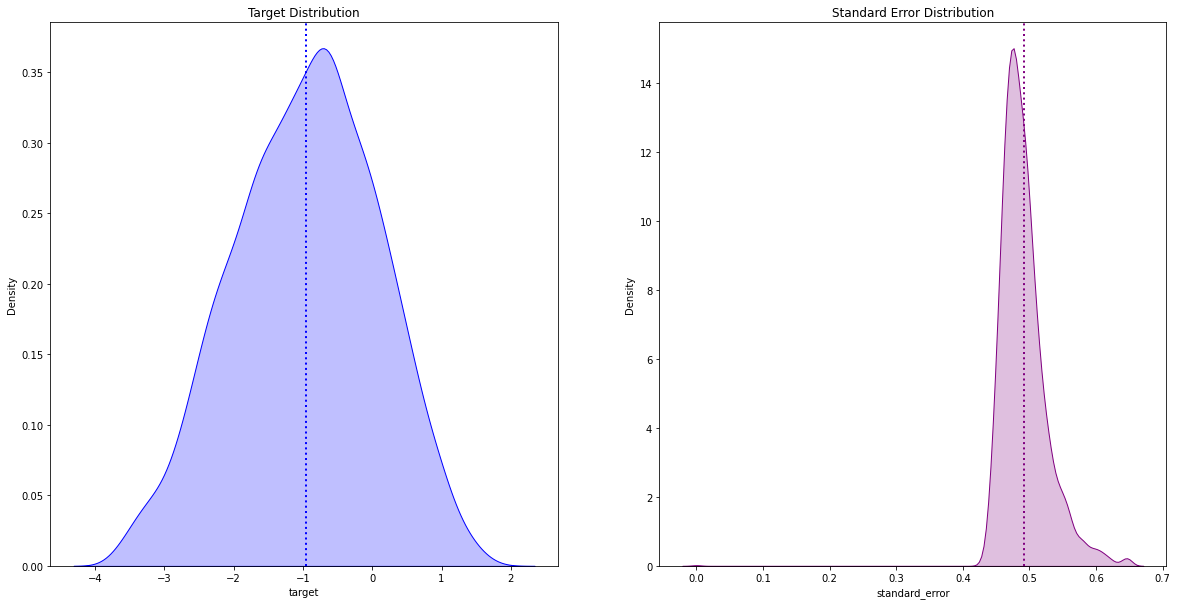

In [13]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
sns.kdeplot(train['target'], color = 'blue', shade = True, ax =ax[0])
sns.kdeplot(train['standard_error'], color = 'purple', shade = True, ax = ax[1])
ax[0].axvline(train['target'].mean(), color ='blue', linestyle = ':', linewidth =2)
ax[1].axvline(train['standard_error'].mean(), color ='purple', linestyle = ':', linewidth =2)
ax[0].set_title('Target Distribution')
ax[1].set_title('Standard Error Distribution')

plt.show()

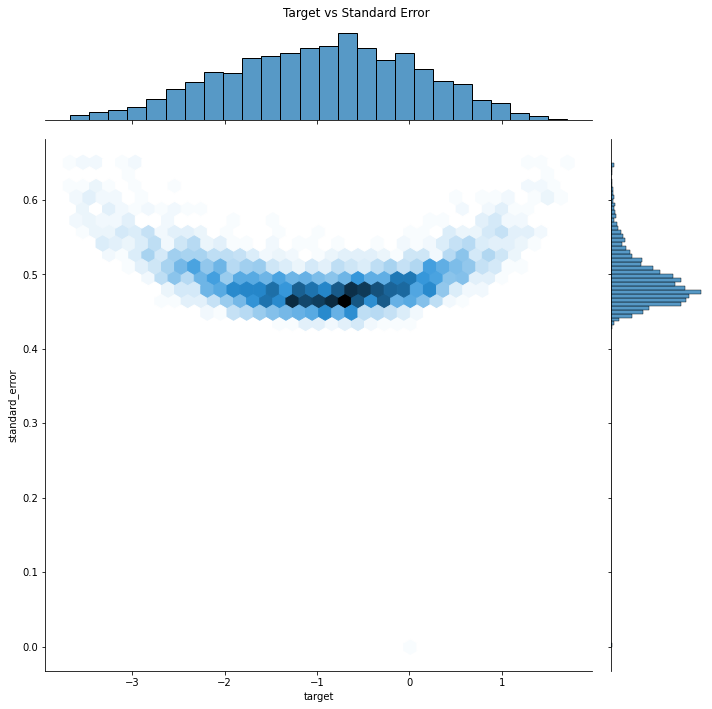

In [14]:
sns.jointplot(x = train['target'],
             y = train['standard_error'],
             kind ='hex', height =10)
plt.suptitle('Target vs Standard Error')
plt.subplots_adjust(top =0.95)
plt.show()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
def get_top_n_words(corpus, n = None):
    vec = CV().fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis =0)
    words_freq =[(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [17]:
def get_top_n_bigram(corpus, n = None):
    vec = CV(ngram_range=(2,2)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis =0)
    words_freq =[(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [18]:
def get_top_n_trigram(corpus, n = None):
    vec = CV(ngram_range=(3,3)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis =0)
    words_freq =[(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [19]:
def plot(x,w):
    common_words = x(train['cleaned_text'], 20)
    common_words_df = pd.DataFrame(common_words, columns =['word', 'freq'])
    plt.figure(figsize = (16,8))
    ax = sns.barplot(x = 'freq', y ='word', data = common_words_df, facecolor = (0,0,0,0), 
                     linewidth =3, edgecolor = sns.color_palette("ch:start=3, rot =.1", 20))

    plt.title('Top 20 '+ w)
    plt.xlabel('Frequency')
    plt.yticks(fontsize = 13)
    plt.xticks(rotation =45)
    plt.show()
    

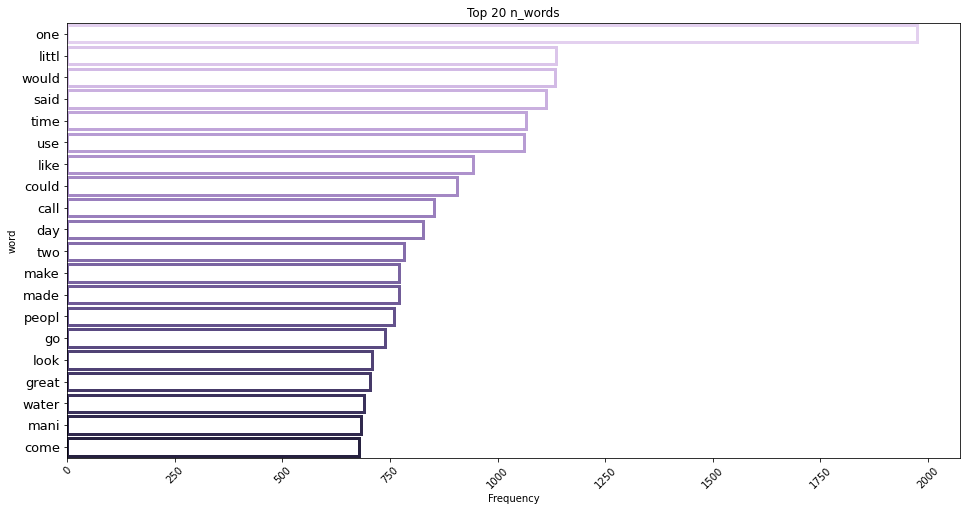

In [22]:
plot(get_top_n_words,'n_words')

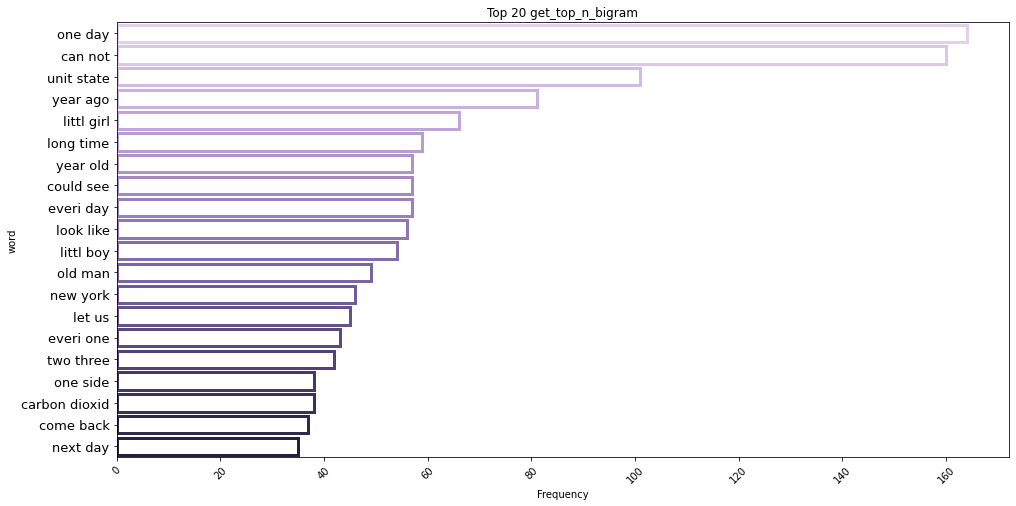

In [23]:
plot(get_top_n_bigram,'get_top_n_bigram')

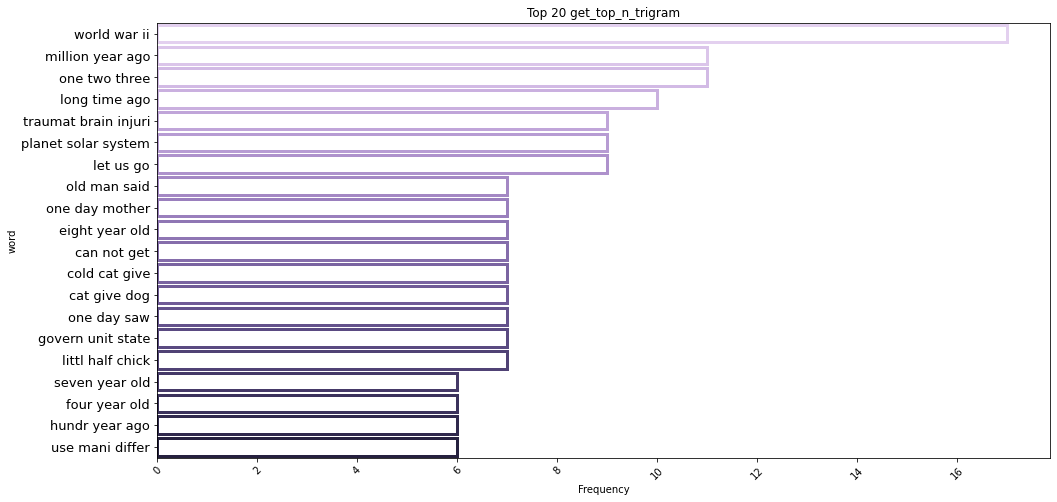

In [24]:
plot(get_top_n_trigram,'get_top_n_trigram')